In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoplot as gplt
import shapefile
import osr
import dbf
import requests
import io

from urllib.request import urlopen
from zipfile import ZipFile
from shapely.geometry import shape, Point, Polygon


%matplotlib inline

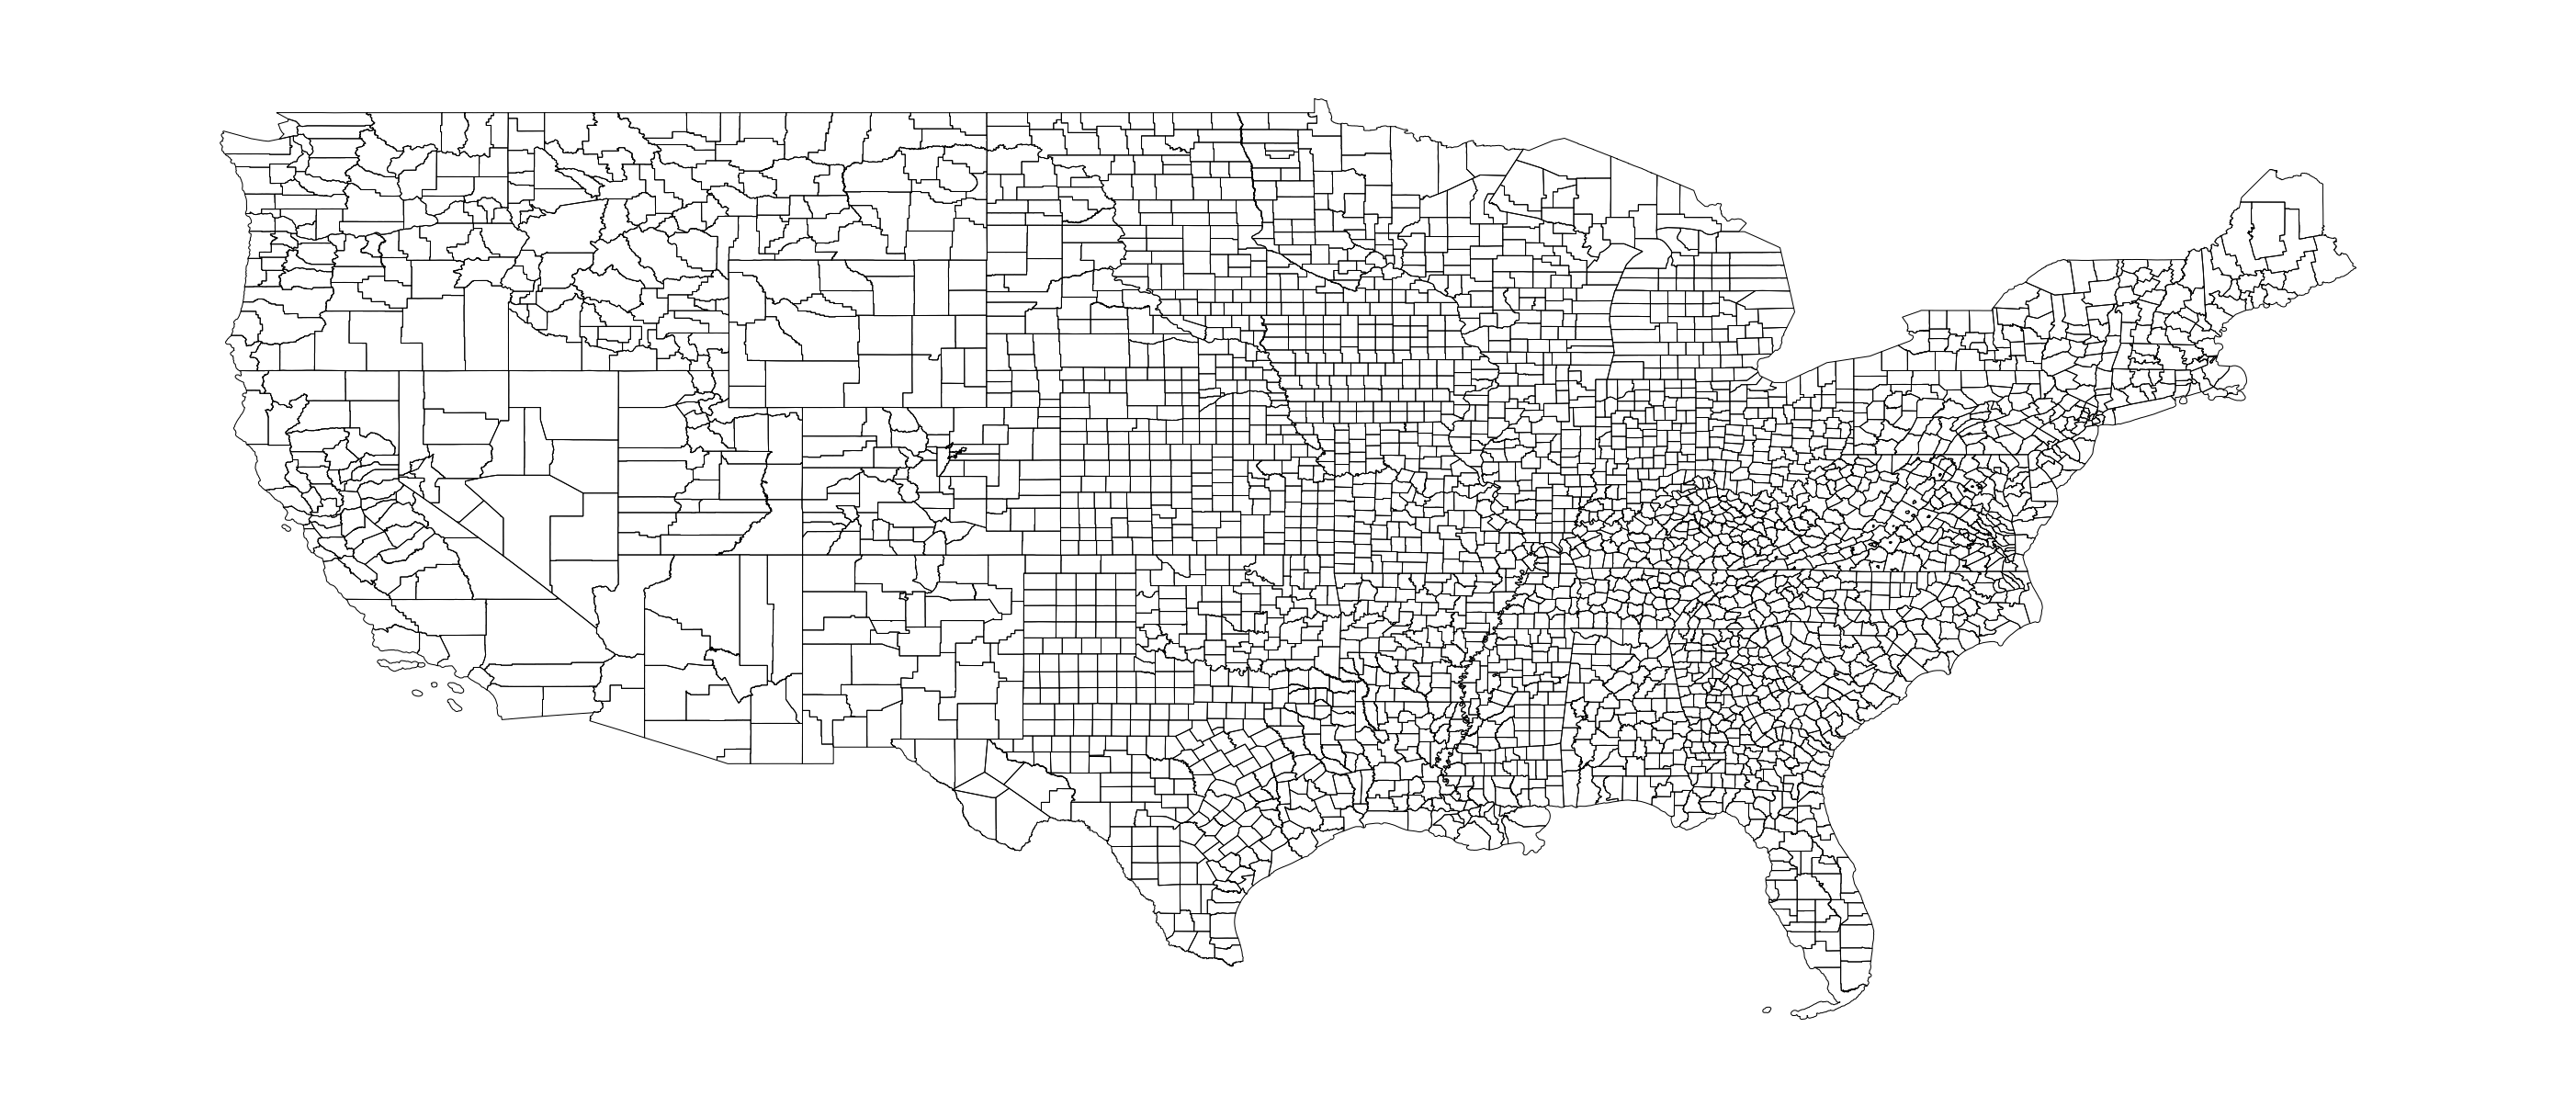

In [2]:
# All counties

## dbf_df = gpd.read_file('tl_2010_us_county10.dbf')
## dbf_df.drop(['NAME10', 'NAMELSAD10'], axis=1, inplace=True)
## dbf_df.to_file('tl_2010_us_county10(NEW).dbf')

allcounties = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_county10(NEW).zip', 'r')

filenames_ac = [y for y in sorted(allcounties.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_ac, prj_ac, shp_ac, shx_ac = [io.BytesIO(allcounties.read(filename)) for filename in filenames_ac]

r_ac = shapefile.Reader(shp=shp_ac, shx=shx_ac, dbf=dbf_ac)
## r_ac.numRecords   ### 3221


attributes, geometry = [], []

field_names = [field[0] for field in r_ac.fields[1:]]

for row in r_ac.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_ac, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_ac = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_ac.sort_values(by =['STATEFP10', 'COUNTYFP10'], inplace=True)
gdf_ac.reset_index(drop=True, inplace=True)
gdf_ac[['INTPTLON10', 'INTPTLAT10']] = gdf_ac[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)

gdf_ac = gdf_ac[(gdf_ac.STATEFP10 != '02') & 
                (gdf_ac.STATEFP10 != '72') & 
                (gdf_ac.STATEFP10 != '15')]

gplt.polyplot(gdf_ac, figsize=(50, 70))

In [3]:
## Read Shapefile data(blocks within state)
s01_blocks = ZipFile('/home/jinli/PycharmProjects/tl_2010_01_tabblock10.zip', 'r') 

filenames_s01 = [y for y in sorted(s01_blocks.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_s01, prj_s01, shp_s01, shx_s01 = [io.BytesIO(s01_blocks.read(filename)) for filename in filenames_s01]

r_s01 = shapefile.Reader(shp=shp_s01, shx=shx_s01, dbf=dbf_s01)

## Generate geodataframe with population weighted centroids
attributes_s01, geometry_s01 = [], []

field_names = [field[0] for field in r_s01.fields[1:]]

for row in r_s01.shapeRecords():
    geometry_s01.append(shape(row.shape.__geo_interface__))
    attributes_s01.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_s01, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_s01 = gpd.GeoDataFrame(data=attributes_s01, geometry=geometry_s01, crs=proj4)
gdf_s01[['INTPTLON10', 'INTPTLAT10']] = gdf_s01[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)
gdf_s01.sort_values(['COUNTYFP10', 'BLOCKCE10', 'TRACTCE10'], ascending=[True, True, True], inplace=True)
gdf_s01.reset_index(drop=True, inplace=True)

pop_s01 = pd.read_csv('/home/jinli/PycharmProjects/DECENNIALSF12010.P1_data_with_overlays_2020-08-31T140516.csv', header=1)
pop_s01['GEOID10'] = pop_s01['id'].map(lambda x: x[9:])
### cols = pop_s01.columns.tolist()   ## ['id', 'Geographic Area Name', 'Total', 'GEOID10']
pop_s01 = pop_s01[['id', 'Geographic Area Name', 'GEOID10', 'Total']]

geodata_s01 = pd.merge(gdf_s01, pop_s01, on='GEOID10')
geodata_s01 = geodata_s01[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'BLOCKCE10', 'geometry', 
                           'Total', 'INTPTLON10', 'INTPTLAT10', 'Geographic Area Name']]
geodata_s01['count'] = 1

geodata_s01['LON*POP'] = geodata_s01['Total']*geodata_s01['INTPTLON10']
geodata_s01['LAT*POP'] = geodata_s01['Total']*geodata_s01['INTPTLAT10']

### Sum up blocks' data by counties within state
s01_ac = geodata_s01.groupby(['STATEFP10', 'COUNTYFP10'])['Total', 'LON*POP', 'LAT*POP', 'count', 
                                                          'INTPTLON10', 'INTPTLAT10'].sum().reset_index()
### Calculate weighted/unweighted centroid 
s01_ac['w.LON'] = s01_ac['LON*POP']/s01_ac['Total']
s01_ac['w.LAT'] = s01_ac['LAT*POP']/s01_ac['Total']
s01_ac['LON'] = s01_ac['INTPTLON10']/s01_ac['count']
s01_ac['LAT'] = s01_ac['INTPTLAT10']/s01_ac['count']
s01_ac = s01_ac[['STATEFP10', 'COUNTYFP10', 'Total', 'w.LON', 'w.LAT', 'count', 'LON', 'LAT']]

u_s01 = s01_ac[['STATEFP10', 'COUNTYFP10', 'LON', 'LAT']]
w_s01 = s01_ac[['STATEFP10', 'COUNTYFP10', 'w.LON', 'w.LAT']].rename({'w.LON': 'LON', 
                                                                      'w.LAT': 'LAT'}, axis=1)

w_s01['Weighted'] = 1
u_s01['Weighted'] = 0

s01_ac = pd.concat([w_s01, u_s01]).sort_values(by='COUNTYFP10', ascending=True).reset_index(drop=True)

### Creat new geodataframe with centroid points transfromed to geometry
geometry_s01 = [Point(xy) for xy in zip(s01_ac['LON'], s01_ac['LAT'])]
cent_s01 = gpd.GeoDataFrame(s01_ac, geometry=geometry_s01)

cent_s01['GEOID10'] = cent_s01['STATEFP10'] + cent_s01['COUNTYFP10']
GEOID10 = cent_s01['GEOID10']
cent_s01.drop(labels=['GEOID10'], axis=1, inplace = True)
cent_s01.insert(0, 'GEOID10', GEOID10)

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
## Read Shapefile data(blocks within state)
s12_blocks = ZipFile('/home/jinli/PycharmProjects/tl_2010_12_tabblock10.zip', 'r') 

filenames_s12 = [y for y in sorted(s12_blocks.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_s12, prj_s12, shp_s12, shx_s12 = [io.BytesIO(s12_blocks.read(filename)) for filename in filenames_s12]

r_s12 = shapefile.Reader(shp=shp_s12, shx=shx_s12, dbf=dbf_s12)

## Generate geodataframe with population weighted centroids
attributes_s12, geometry_s12 = [], []

field_names = [field[0] for field in r_s12.fields[1:]]

for row in r_s12.shapeRecords():
    geometry_s12.append(shape(row.shape.__geo_interface__))
    attributes_s12.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_s12, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_s12 = gpd.GeoDataFrame(data=attributes_s12, geometry=geometry_s12, crs=proj4)
gdf_s12[['INTPTLON10', 'INTPTLAT10']] = gdf_s12[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)
gdf_s12.sort_values(['COUNTYFP10', 'BLOCKCE10', 'TRACTCE10'], ascending=[True, True, True], inplace=True)
gdf_s12.reset_index(drop=True, inplace=True)

pop_s12 = pd.read_csv('/home/jinli/PycharmProjects/DECENNIALSF12010.P1_data_with_overlays_2020-09-05T003736.csv', header=1)
pop_s12['GEOID10'] = pop_s12['id'].map(lambda x: x[9:])
### cols = pop_s12.columns.tolist()   ## ['id', 'Geographic Area Name', 'Total', 'GEOID10']
pop_s12 = pop_s12[['id', 'Geographic Area Name', 'GEOID10', 'Total']]

geodata_s12 = pd.merge(gdf_s12, pop_s12, on='GEOID10')
geodata_s12 = geodata_s12[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'BLOCKCE10', 'geometry', 
                           'Total', 'INTPTLON10', 'INTPTLAT10', 'Geographic Area Name']]
geodata_s12['count'] = 1

geodata_s12['LON*POP'] = geodata_s12['Total']*geodata_s12['INTPTLON10']
geodata_s12['LAT*POP'] = geodata_s12['Total']*geodata_s12['INTPTLAT10']

### Sum up blocks' data by counties within state
s12_ac = geodata_s12.groupby(['STATEFP10', 'COUNTYFP10'])['Total', 'LON*POP', 'LAT*POP', 'count', 
                                                          'INTPTLON10', 'INTPTLAT10'].sum().reset_index()
### Calculate weighted/unweighted centroid 
s12_ac['w.LON'] = s12_ac['LON*POP']/s12_ac['Total']
s12_ac['w.LAT'] = s12_ac['LAT*POP']/s12_ac['Total']
s12_ac['LON'] = s12_ac['INTPTLON10']/s12_ac['count']
s12_ac['LAT'] = s12_ac['INTPTLAT10']/s12_ac['count']
s12_ac = s12_ac[['STATEFP10', 'COUNTYFP10', 'Total', 'w.LON', 'w.LAT', 'count', 'LON', 'LAT']]

u_s12 = s12_ac[['STATEFP10', 'COUNTYFP10', 'LON', 'LAT']]
w_s12 = s12_ac[['STATEFP10', 'COUNTYFP10', 'w.LON', 'w.LAT']].rename({'w.LON': 'LON', 
                                                                      'w.LAT': 'LAT'}, axis=1)

w_s12['Weighted'] = 1
u_s12['Weighted'] = 0

s12_ac = pd.concat([w_s12, u_s12]).sort_values(by='COUNTYFP10', ascending=True).reset_index(drop=True)

### Creat new geodataframe with centroid points transfromed to geometry
geometry_s12 = [Point(xy) for xy in zip(s12_ac['LON'], s12_ac['LAT'])]
cent_s12 = gpd.GeoDataFrame(s12_ac, geometry=geometry_s12)

cent_s12['GEOID10'] = cent_s12['STATEFP10'] + cent_s12['COUNTYFP10']
GEOID10 = cent_s12['GEOID10']
cent_s12.drop(labels=['GEOID10'], axis=1, inplace = True)
cent_s12.insert(0, 'GEOID10', GEOID10)

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
centroid_frames = [cent_s01, cent_s12]
centroids = pd.concat(centroid_frames)

block_frames = [gdf_s01, gdf_s12]
blocks = pd.concat(block_frames) 

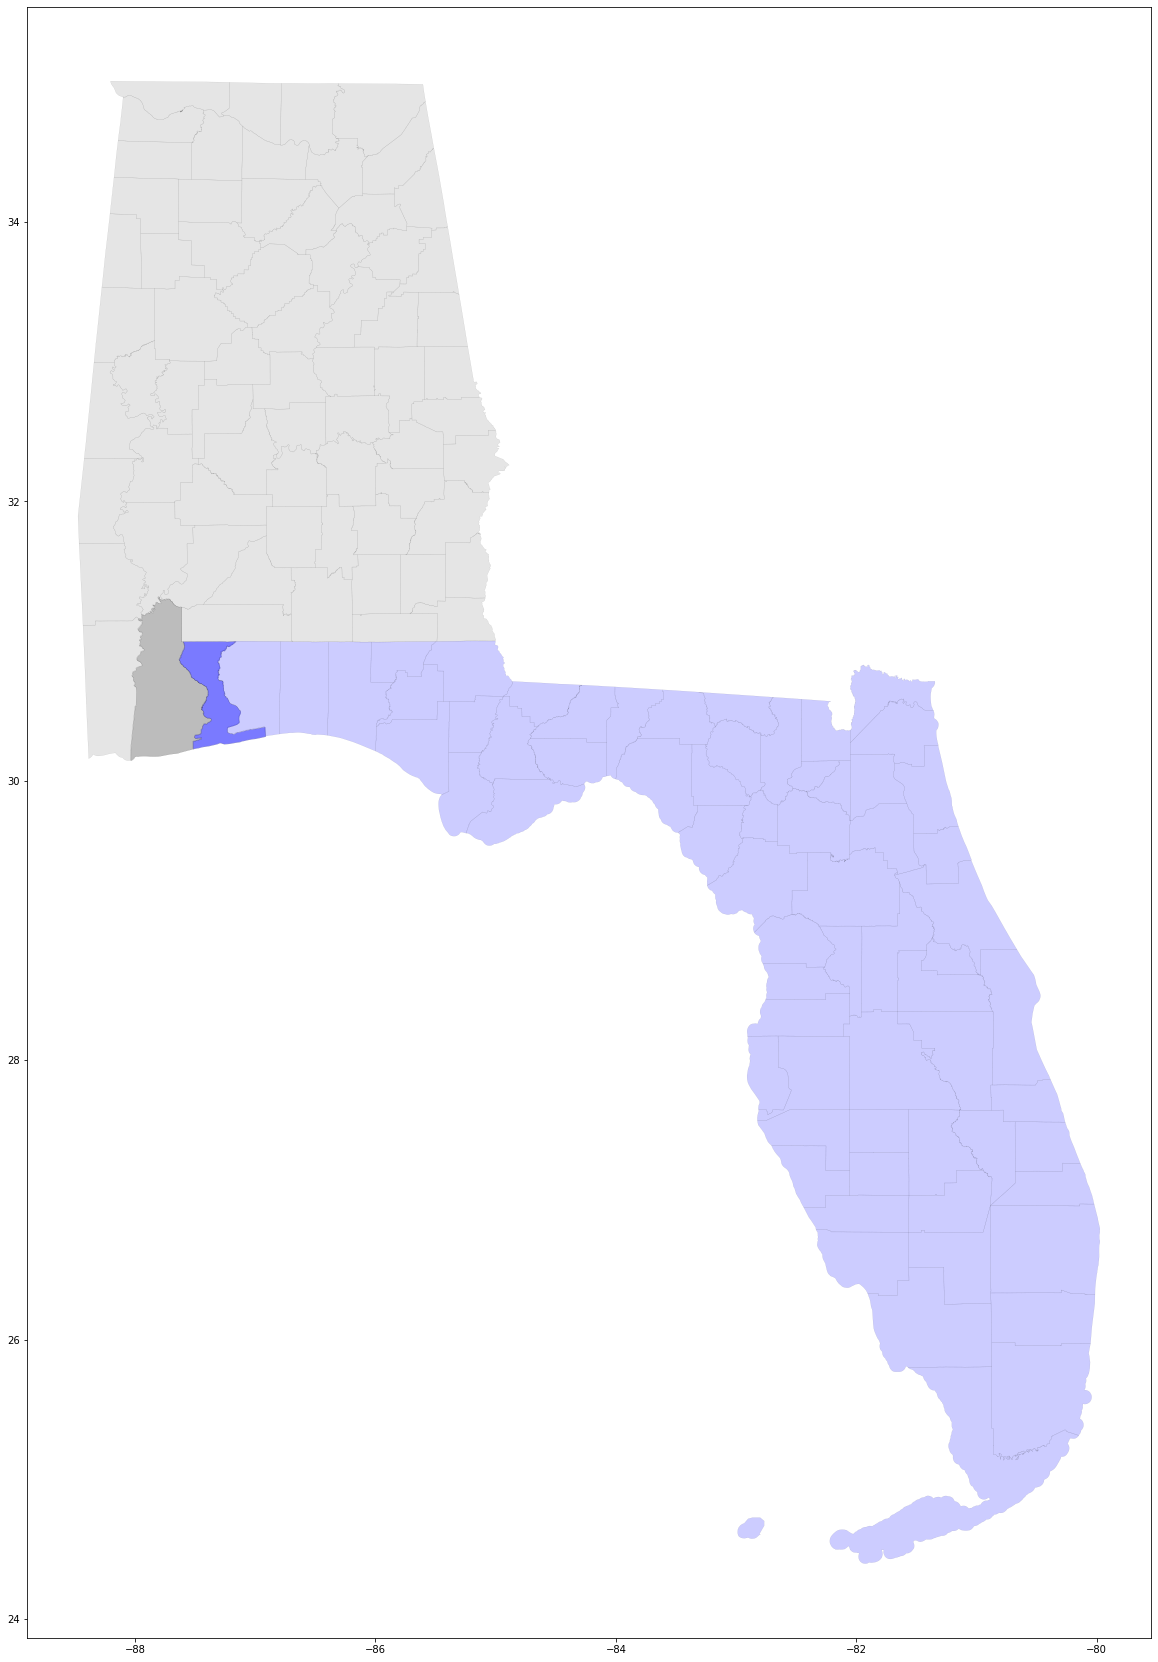

In [6]:
## States plot of Alabama(01) and Florida(12)

fig1, ax = plt.subplots(figsize=(30,30))

gdf_ac[gdf_ac.STATEFP10=='01'].plot(ax=ax, alpha=0.2, color='grey', linewidth=0.2, edgecolor='black')
gdf_ac[(gdf_ac.STATEFP10=='01') & (gdf_ac.COUNTYFP10 == '003')].plot(ax=ax, alpha=0.4, 
                                                                     color='grey', linewidth=0.2, edgecolor='black')
gdf_ac[gdf_ac.STATEFP10=='12'].plot(ax=ax, alpha=0.2, color='blue', linewidth=0.2, edgecolor='black')
gdf_ac[(gdf_ac.STATEFP10=='12') & (gdf_ac.COUNTYFP10 == '033')].plot(ax=ax, alpha=0.4, 
                                                                     color='blue', linewidth=0.2, edgecolor='black')

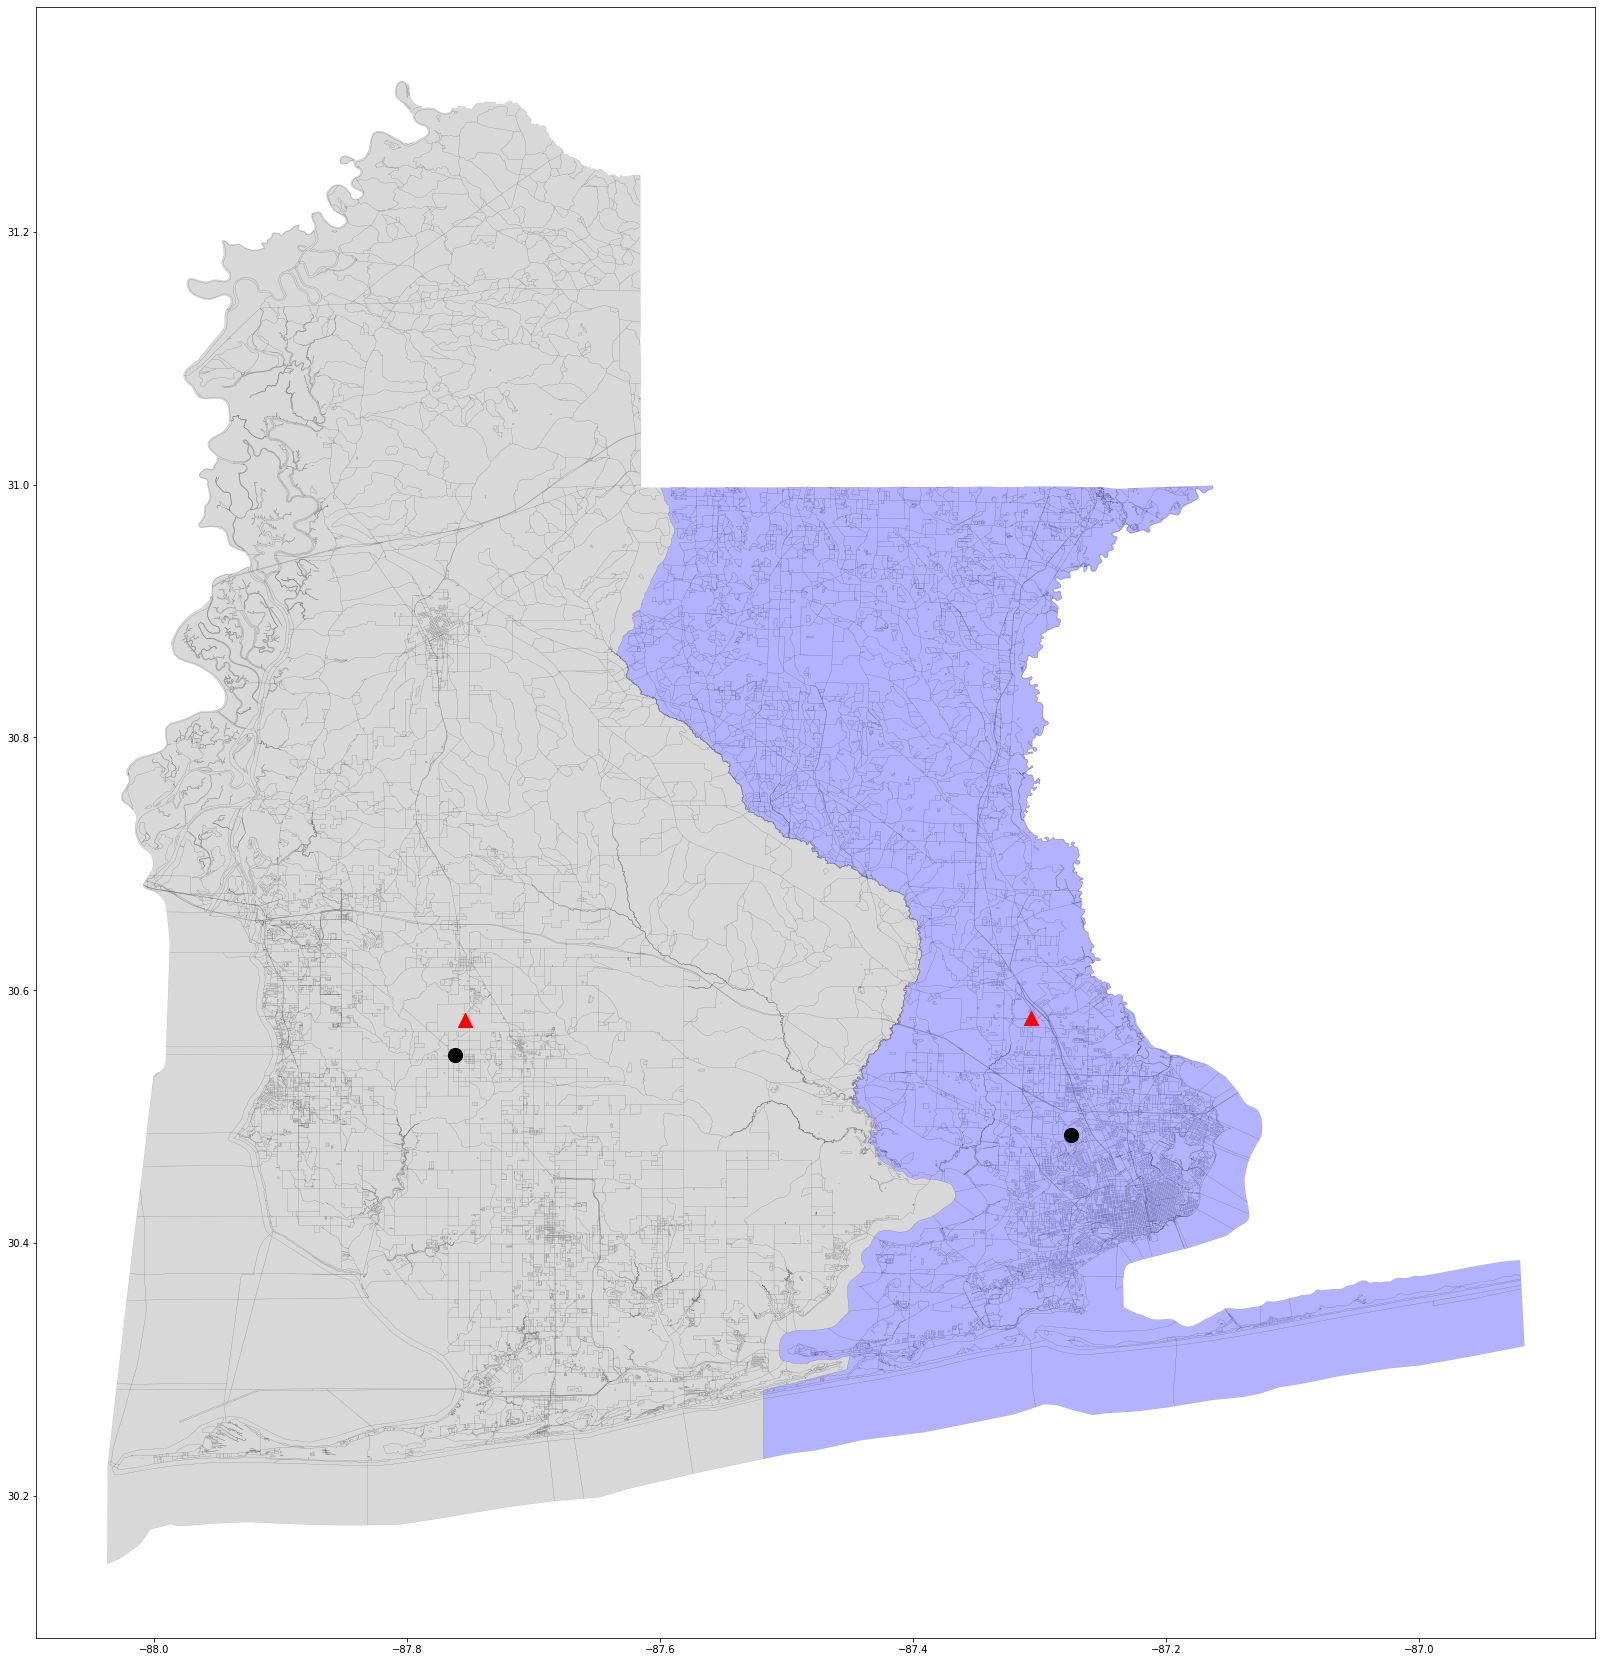

In [7]:
fig2, ax = plt.subplots(figsize=(30,30))

blocks[(blocks.STATEFP10=='01') & (blocks.COUNTYFP10=='003')].plot(ax=ax, alpha=0.3, color='grey', linewidth=0.2, edgecolor='black')
blocks[(blocks.STATEFP10=='12') & (blocks.COUNTYFP10=='033')].plot(ax=ax, alpha=0.3, color='blue', linewidth=0.2, edgecolor='black')

centroids[(centroids.Weighted==1) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='black', marker='o')
centroids[(centroids.Weighted==1) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='black', marker='o')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='red', marker='^')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='red', marker='^')

In [8]:
## County Boundary Dataframe: cbd
cbd = gdf_ac[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'geometry']]
c01003 = cbd[cbd.GEOID10=='01003'].geometry
c12033 = cbd[cbd.GEOID10=='12033'].geometry

c01003.reset_index(inplace=True, drop=True)
c12033.reset_index(inplace=True, drop=True)

In [9]:
## County Boundary Intersection: cbi
c01003.touches(c12033) ## 0    True   ## dtype: bool
cbi = c01003.intersection(c12033) ## 0    MULTILINESTRING ((-87.59883 30.99745, -87.5988...
### type(cbi) ### geopandas.geoseries.GeoSeries

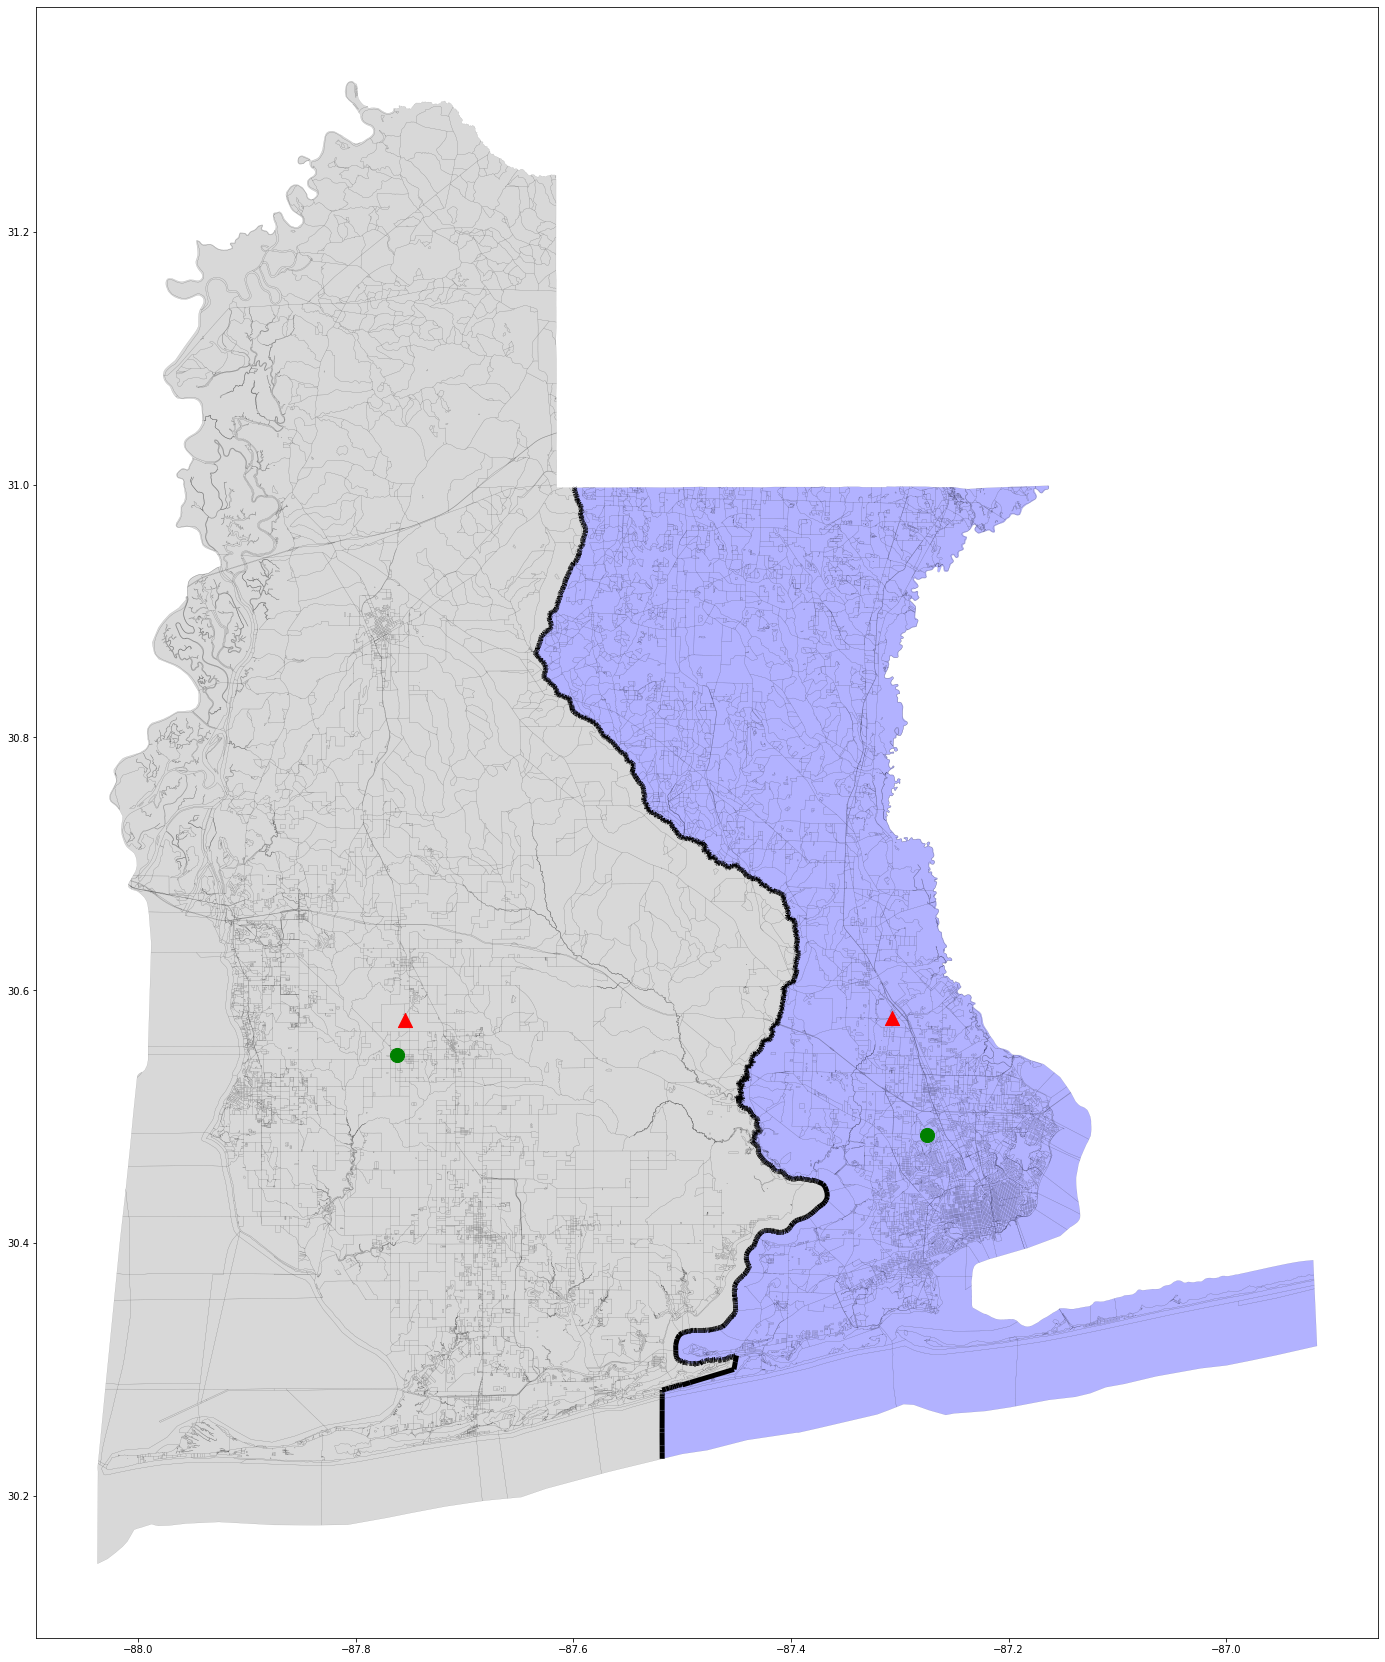

In [10]:
fig3, ax = plt.subplots(figsize=(30,30))

blocks[(blocks.STATEFP10=='01') & (blocks.COUNTYFP10=='003')].plot(ax=ax, alpha=0.3, color='grey', linewidth=0.2, edgecolor='black')
blocks[(blocks.STATEFP10=='12') & (blocks.COUNTYFP10=='033')].plot(ax=ax, alpha=0.3, color='blue', linewidth=0.2, edgecolor='black')

centroids[(centroids.Weighted==1) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='green', marker='o')
centroids[(centroids.Weighted==1) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='green', marker='o')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='red', marker='^')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='red', marker='^')

cbi.plot(ax=ax, color='black', linewidth=5)

In [11]:
centroids

,GEOID10,STATEFP10,COUNTYFP10,LON,LAT,Weighted,geometry
0,01001,01,001,-86.494186,32.500389,1,POINT (-86.49419 32.50039)
1,01001,01,001,-86.565149,32.512569,0,POINT (-86.56515 32.51257)
2,01003,01,003,-87.762466,30.548923,1,POINT (-87.76247 30.54892)
3,01003,01,003,-87.754369,30.576464,0,POINT (-87.75437 30.57646)
4,01005,01,005,-85.309929,31.844037,1,POINT (-85.30993 31.84404)
...,...,...,...,...,...,...,...
129,12129,12,129,-84.331514,30.185526,1,POINT (-84.33151 30.18553)
130,12131,12,131,-86.170814,30.594409,0,POINT (-86.17081 30.59441)
131,12131,12,131,-86.190621,30.583729,1,POINT (-86.19062 30.58373)
132,12133,12,133,-85.625363,30.650718,1,POINT (-85.62536 30.65072)


In [12]:
## Weighted centroids
w_cent = centroids[centroids.Weighted==1]
w_cent

,GEOID10,STATEFP10,COUNTYFP10,LON,LAT,Weighted,geometry
0,01001,01,001,-86.494186,32.500389,1,POINT (-86.49419 32.50039)
2,01003,01,003,-87.762466,30.548923,1,POINT (-87.76247 30.54892)
4,01005,01,005,-85.309929,31.844037,1,POINT (-85.30993 31.84404)
6,01007,01,007,-87.127656,33.030921,1,POINT (-87.12766 33.03092)
9,01009,01,009,-86.591401,33.955244,1,POINT (-86.59140 33.95524)
...,...,...,...,...,...,...,...
125,12125,12,125,-82.356888,30.010769,1,POINT (-82.35689 30.01077)
127,12127,12,127,-81.123881,29.073726,1,POINT (-81.12388 29.07373)
129,12129,12,129,-84.331514,30.185526,1,POINT (-84.33151 30.18553)
131,12131,12,131,-86.190621,30.583729,1,POINT (-86.19062 30.58373)


In [13]:
points = w_cent[w_cent.GEOID10=='01003'].geometry     ## type(points) geopandas.geoseries.GeoSeries
points.reset_index(inplace=True, drop=True)
lines = cbi                                           ## type(lines)  geopandas.geoseries.GeoSeries
dist = points.distance(lines)                         ## type(dist)   pandas.core.series.Series
### 0    0.301
### dtype: float64

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=longlat +ellps=GRS80  +type=crs

  after removing the cwd from sys.path.


## County Pairs

In [14]:
countypairs = pd.read_csv('/home/jinli/PycharmProjects/county-pair-list.txt')

countypairs.drop_duplicates(subset='COUNTYPAIR_ID', inplace = True)

new = countypairs['COUNTYPAIR_ID'].str.split("-", n = 1, expand = True)

countypairs['GEOID10_FIPS1'] = new[0]
countypairs['GEOID10_FIPS2'] = new[1]
countypairs['STATE_FIPS1'] = countypairs['GEOID10_FIPS1'].map(lambda x: x[0:2])
countypairs['STATE_FIPS2'] = countypairs['GEOID10_FIPS2'].map(lambda x: x[0:2])

countypairs = countypairs[['COUNTYPAIR_ID', 'STATE_FIPS1', 'GEOID10_FIPS1', 'STATE_FIPS2', 'GEOID10_FIPS2']]
countypairs.reset_index(drop=True, inplace=True)

In [15]:
countypairs.head()

,COUNTYPAIR_ID,STATE_FIPS1,GEOID10_FIPS1,STATE_FIPS2,GEOID10_FIPS2
0,01003-12033,01,01003,12,12033
1,01005-13239,01,01005,13,13239
2,01017-13145,01,01017,13,13145
3,01019-13233,01,01019,13,13233
4,01023-28023,01,01023,28,28023


In [16]:
## Obtain state fips for county pairs.
allstates = pd.concat([countypairs.STATE_FIPS1, countypairs.STATE_FIPS2], 
                      ignore_index=True).drop_duplicates().reset_index(drop=True).tolist()

In [17]:
allstates

['01',
 '04',
 '05',
 '06',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '53',
 '54',
 '55',
 '56']